# Análise de Cluster Não Hierárquico: 
# Elbow e Silhouette
   Legendas:
   * <code style="color:green">Teoria</code>
   * <code style="color:purple">Dicas</code>
   * <code style="color:red">Prática (exemplo ou exercício)</code>

### <code style="color:green">Cluster Não Hierárquico </code>
    
    Utiliza o princípio de jogar pontos aleatórios para então calcular as distâncias e definir grupos.

    E dado o formato de trabalho, não podemos visualizá-los através do dendograma.
    
### <code style="color:green">Sugestão de Grupos </code> 

Podemos fazer avaliações e sugestões do número de grupos através dos métodos:   
    
   * Elbow - mede a variabilidade dentro dos grupos
   * Sillhouette - baseado nas distâncias calcula o s (varia entre -1 e 1) de cada ponto de seu grupo, além de ter o s para cada possível número de cluster a fim de sugerir um número de grupos
       
### <code style="color:purple">Discussão </code> 

Como comentado o StandardScaler (da sklearn) utiliza o desvio padrão populacional, quando o mais adequado seria o desvio padrão amostral. Lembrando que isso tem impacto quando estamos falando de bases não tão grandes. Neste código criamos a função mesma_escala para resolver o ponto.

### <code style="color:purple">Inicializando pacotes e funções criadas </code> 

Carregando o que será necessário:

In [1]:
import pandas as pd # biblioteca para manipulação de dados
from scipy.spatial.distance import pdist, squareform # funções para calcular as distâncias
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster # funções para clusterização
import matplotlib.pyplot as plt # biblioteca para visualização de dados
import tanglegram # biblioteca para a criação do tanglegram
#from sklearn.cluster import AgglomerativeClustering # função para criar os clusters
from sklearn.metrics import silhouette_score, silhouette_samples # função para calcular a silhueta
import numpy as np # biblioteca para calculo
from sklearn.preprocessing import StandardScaler #para colocar os dados na mesma escala - atenção
import seaborn as sns  # biblioteca para visualização de dados
from scipy import stats # biblioteca para análise estatistica
from sklearn.cluster import KMeans #biblioteca para método kmeans
from pandas.plotting import parallel_coordinates #grafico de analise dos clusters
from yellowbrick.cluster import SilhouetteVisualizer #silhueta ponto a ponto
from IPython.core.display import display, HTML #aumentar display para vários gráficos

In [2]:
#Esta função coloca os dados na mesma escala usando a equacao padrao
# (x-xbarra)/sd
# só criei isso porque o Scaler do python divide pelo desvio padrao populacional e não amostral
# em conjuntos não tão grande, isso dá muita diferença
#Parâmetros:
# -data: Conjunto de dados.
#Retorna: Conjunto de dados na mesma escala.

def mesma_escala(data):
    for col in data.columns:
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col] = (data[col] - data[col].mean()) / data[col].std(ddof=1)
    return data

# Exemplo de uso
# mesma_escala(data)

### <code style="color:green">Conjunto de dados </code>

Data Set: Wholesale Customers
O conjunto de dados contém informações sobre os gastos anuais de diferentes clientes em várias categorias de produtos (como produtos frescos, leite, mercearia, etc.), além de informações sobre a região e o canal de vendas utilizado.


| **Variável**          | **Descrição**                                                                                        |
|---------------------|------------------------------------------------------------------------------------------------------|
| `Channel`           | O canal de vendas utilizado pelo cliente. (1: Horeca (Hotel/Restaurante/Café) / 2: Varejista.)        |
| `Region`            | A região onde o cliente está localizado. (1: Lisboa / 2: Porto / 3: Outras regiões.)                  |
| `Fresh`             | Gastos anuais do cliente com produtos frescos (frutas, vegetais, etc.) em unidades monetárias.        |
| `Milk`              | Gastos anuais do cliente com produtos lácteos (leite, queijos, etc.).                                 |
| `Grocery`           | Gastos anuais do cliente com mantimentos (alimentos embalados, enlatados, etc.).                      |
| `Frozen`            | Gastos anuais do cliente com produtos congelados.                                                     |
| `Detergents_Paper`  | Gastos anuais do cliente com produtos de limpeza e papel.                                             |
| `Delicassen`        | Gastos anuais do cliente com itens de delicatessen (produtos finos como carnes frias, queijos especiais, etc.). |


In [3]:
# importando base de dados
wholesale_customers = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
wholesale_customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
wholesale_customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [5]:
#padronizando as variáveis conforme a funçao criada
wholesale_customers_pad  = mesma_escala(wholesale_customers.drop(columns=['Channel', 'Region']))
wholesale_customers_pad.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052873,0.522972,-0.041068,-0.588697,-0.043519,-0.066264
1,-0.390857,0.543839,0.170125,-0.269829,0.086309,0.089050
2,-0.446521,0.408073,-0.028125,-0.137379,0.133080,2.240742
3,0.099998,-0.623310,-0.392530,0.686363,-0.498021,0.093305
4,0.839284,-0.052337,-0.079266,0.173661,-0.231654,1.297870


### <code style="color:green">Analisando Elbow e Silhueta </code>

Analisando Elbow e Silhueta para definir uma sugestão de número de grupos

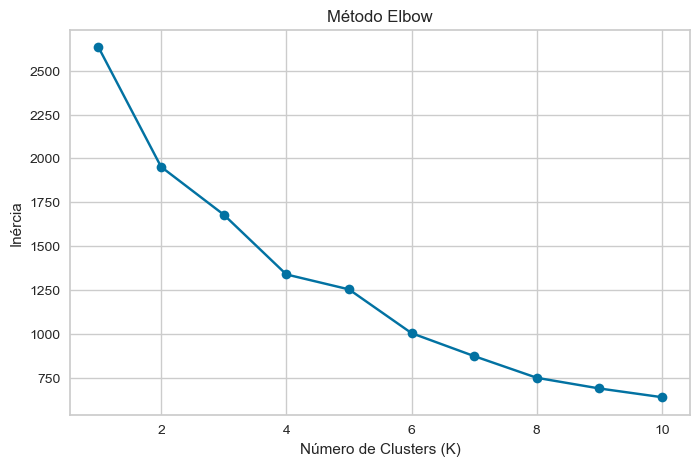

In [6]:
# elbow para método kmeans
lista_soma = [KMeans(n_clusters=cluster, random_state=1987).fit(wholesale_customers_pad).inertia_ \
              for cluster in range(1,11)  ]


plt.figure(figsize=(8, 5))
plt.plot(range(1,11), lista_soma, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.title('Método Elbow')
plt.show()

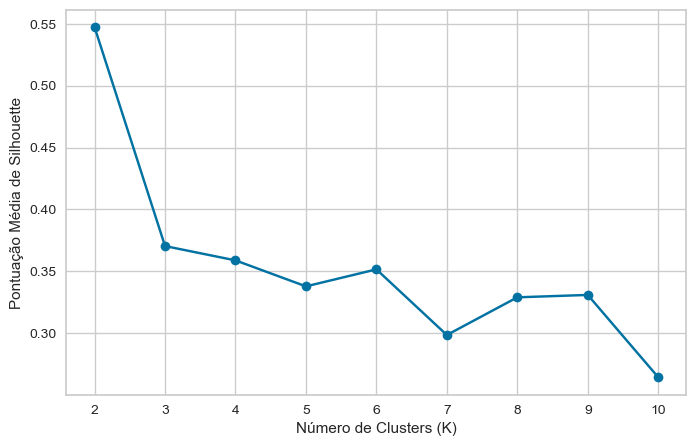

In [7]:
# silhueta para método kmeans
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1987)
    cluster_labels = kmeans.fit_predict(wholesale_customers_pad)
    silhouette_avg = silhouette_score(wholesale_customers_pad, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico de Silhouette
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Pontuação Média de Silhouette')
plt.show()

### <code style="color:purple">Discussão </code> 

Vou investir na anáise de 4 grupos (decidi pela variabilidade do Elbow).

Mas sem dúvida seria interessante fazer isso com algumas possibilidades e ver o que fica mais interessante pro contexto

C:\Users\adria\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


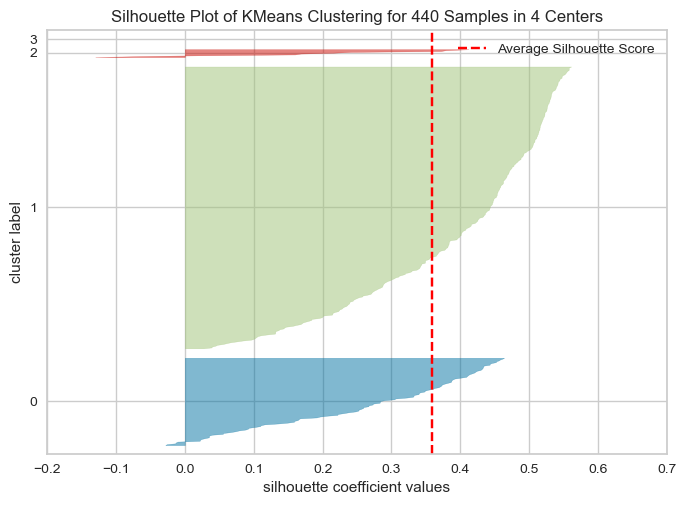

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 440 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [10]:
#observando a silhueta ponto a ponto com a escolha de 5 grupos
# Ajustar o modelo KMeans
kmeans = KMeans(n_clusters=4, random_state=1987)
model = kmeans.fit(wholesale_customers_pad)

# Criar o visualizador Silhouette
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

# Gerar o gráfico
visualizer.fit(wholesale_customers_pad)  
visualizer.show()    

In [11]:
# adicionando a marcação dos grupos na base padronizada e na original
wholesale_customers_pad['cluster'] = kmeans.labels_
wholesale_customers['cluster'] = kmeans.labels_
wholesale_customers

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,2,3,12669,9656,7561,214,2674,1338,1
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,1
...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,1
436,1,3,39228,1431,764,4510,93,2346,1
437,2,3,14531,15488,30243,437,14841,1867,0
438,1,3,10290,1981,2232,1038,168,2125,1


In [12]:
#calculando estatísticas descritivas da base original, conforme os cluster criados

#retirei as variaveis categorias (não faz sentido fazer média com elas) e pedi o describe
grouped = wholesale_customers.drop(columns=['Region', 'Channel']).groupby('cluster').describe()
#pedi para transpor a tabela para poder visualizar melhor a saída
grouped_transposed = grouped.stack(level=0).reset_index()
#mudei o nome da varival level_1 para variavels
grouped_transposed = grouped_transposed.rename(columns={'level_1': 'variavel'})
#determinei a ordem que gostaria de ver na tabela
ordered_columns = ['cluster', 'variavel', 'count', 'min', '25%', '50%', '75%', 'max', 'mean', 'std']
grouped_transposed = grouped_transposed[ordered_columns]
grouped_transposed
#adicionei cor nas linhas da tabela para ficar mais fácil visualizar
def color_rows(row):
    if row['cluster'] == 0:
        return ['background-color: #A1CAF1'] * len(row)  # azul clarinho
    elif row['cluster'] == 1:
        return ['background-color: #FDFD96'] * len(row)  # amarelo clarinho
    elif row['cluster'] == 2:
        return ['background-color: #FFB347'] * len(row)  # laranja clarinho
    elif row['cluster'] == 3:
        return ['background-color: #B19CD9'] * len(row)  # roxo clarinho
    elif row['cluster'] == 4:
        return ['background-color: #77DD77'] * len(row)  # verde clarinho
styled_table = grouped_transposed.style.apply(color_rows, axis=1)
#ptonto
styled_table

C:\Users\adria\AppData\Local\Temp\ipykernel_28204\2034764330.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  grouped_transposed = grouped.stack(level=0).reset_index()


,cluster,variavel,count,min,25%,50%,75%,max,mean,std
0,0,Delicassen,102.000000,3.000000,668.000000,1409.500000,2309.750000,16523.000000,2018.509804,2547.586463
1,0,Detergents_Paper,102.000000,282.000000,4630.000000,6717.500000,8662.500000,17120.000000,7024.333333,3318.988231
2,0,Fresh,102.000000,18.000000,1428.500000,4422.500000,9246.250000,112151.000000,7129.156863,12339.731098
3,0,Frozen,102.000000,25.000000,407.750000,957.000000,1900.000000,16745.000000,1626.215686,2172.157857
4,0,Grocery,102.000000,4748.000000,11524.500000,14870.500000,20372.250000,36486.000000,16411.049020,6228.232177
5,0,Milk,102.000000,1266.000000,6979.750000,9721.000000,12815.250000,36423.000000,10829.441176,5891.273297
6,1,Delicassen,327.000000,3.000000,376.500000,823.000000,1551.500000,14351.000000,1185.577982,1315.069710
7,1,Detergents_Paper,327.000000,3.000000,204.500000,436.000000,1140.000000,5316.000000,924.721713,1117.934631
8,1,Fresh,327.000000,3.000000,4433.000000,9784.000000,18149.500000,76237.000000,13322.510703,12286.174761
9,1,Frozen,327.000000,47.000000,830.000000,1765.000000,4207.000000,60869.000000,3421.088685,5085.725186


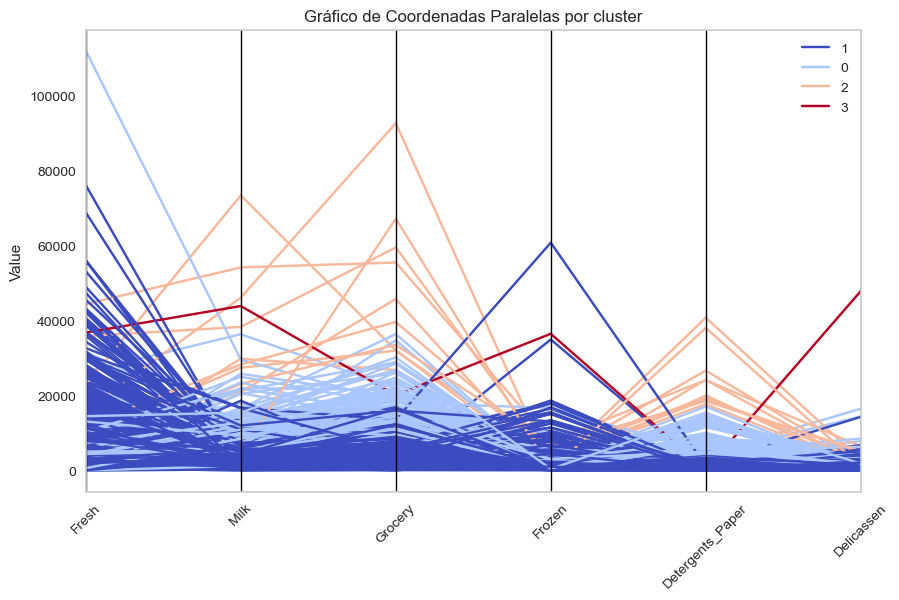

In [13]:
# criando o gráfico de coordenadas paralelas por cluster
numeric_vars = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen', 'cluster']
df_plot = wholesale_customers[numeric_vars]

# Plot de coordenadas paralelas
plt.figure(figsize=(10, 6))
parallel_coordinates(df_plot, class_column='cluster', colormap=plt.get_cmap("coolwarm"))
plt.title('Gráfico de Coordenadas Paralelas por cluster')
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.show()


C:\Users\adria\AppData\Local\Temp\ipykernel_28204\2265336531.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x='Grupo', y=var, data=wholesale_customers_combined, palette='Set1', order=order)
C:\Users\adria\AppData\Local\Temp\ipykernel_28204\2265336531.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x='Grupo', y=var, data=wholesale_customers_combined, palette='Set1', order=order)
C:\Users\adria\AppData\Local\Temp\ipykernel_28204\2265336531.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x='Grupo', y=var, da

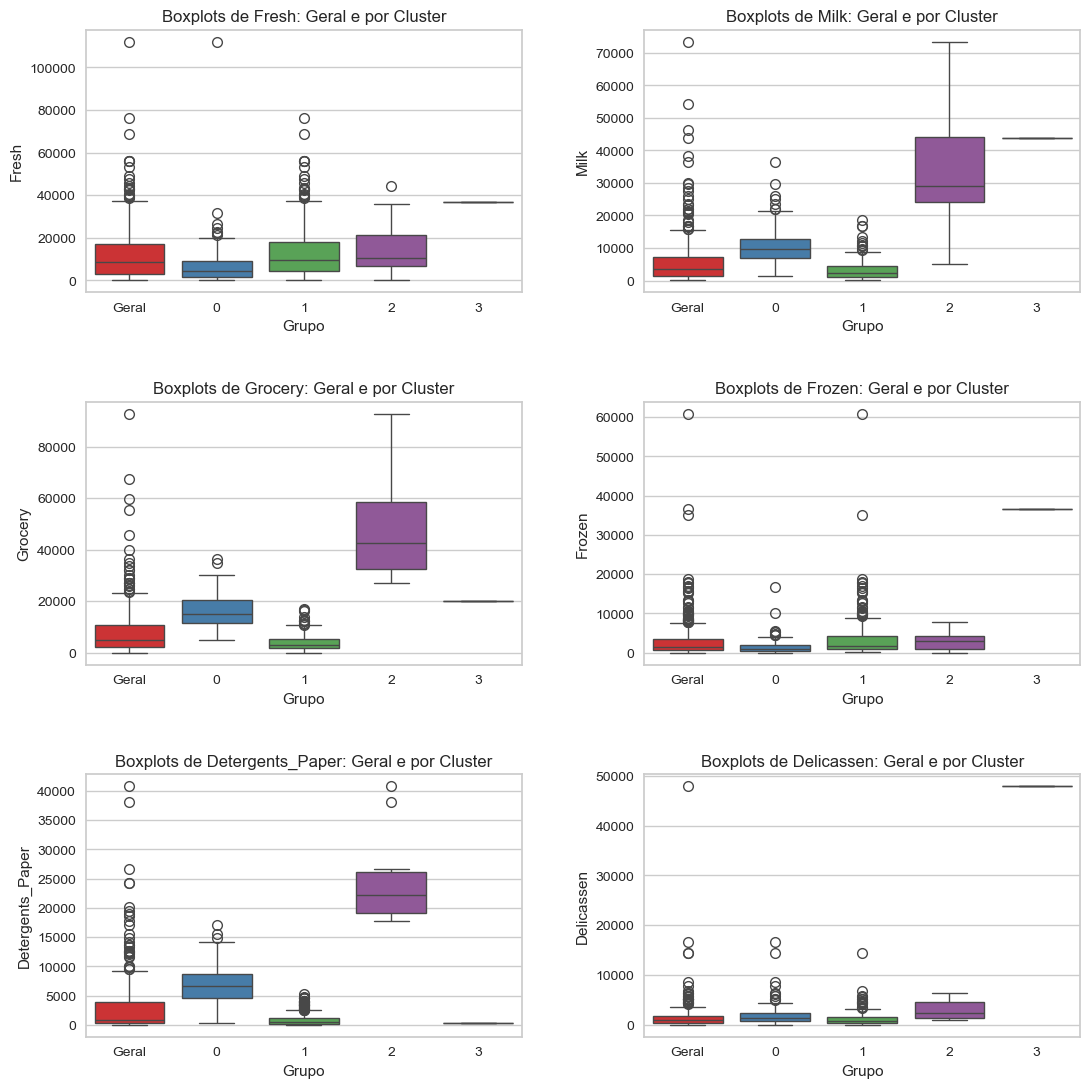

In [15]:
vars_analise = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Definir quantos gráficos por linha (exemplo: 2)
graficos_por_linha = 2
# Calcular o número de linhas necessárias
num_linhas = -(-len(vars_analise) // graficos_por_linha)  
# Criar figura de subplots
fig, axes = plt.subplots(num_linhas, graficos_por_linha, figsize=(12, 4 * num_linhas))
# Ajustar o layout dos subplots
fig.tight_layout(pad=5.0)

for i, var in enumerate(vars_analise):
    ax = axes[i // graficos_por_linha, i % graficos_por_linha]  # Seleciona a posição correta do subplot
    
    # Criar uma nova coluna 'Grupo' que mantém os clusters e adiciona 'Geral' apenas para a plotagem
    wholesale_customers['Grupo'] = wholesale_customers['cluster'].astype(str)
    
    # Criar uma cópia temporária para o grupo 'Geral' contendo todas as observações
    wholesale_customers_geral = wholesale_customers.copy()
    wholesale_customers_geral['Grupo'] = 'Geral'
    
    # Concatenar os dados para garantir que 'Geral' contenha todos os dados e os clusters fiquem separados
    wholesale_customers_combined = pd.concat([wholesale_customers, wholesale_customers_geral])
    
    # Definir a ordem das categorias com 'Geral' na primeira posição
    order = ['Geral'] + sorted(wholesale_customers['cluster'].unique().astype(str))
    
    # Plotar o boxplot geral e por cluster no subplot
    sns.boxplot(ax=ax, x='Grupo', y=var, data=wholesale_customers_combined, palette='Set1', order=order)
    
    # Ajustar o título e rótulos
    ax.set_title(f'Boxplots de {var}: Geral e por Cluster')
    ax.set_xlabel('Grupo')
    ax.set_ylabel(var)

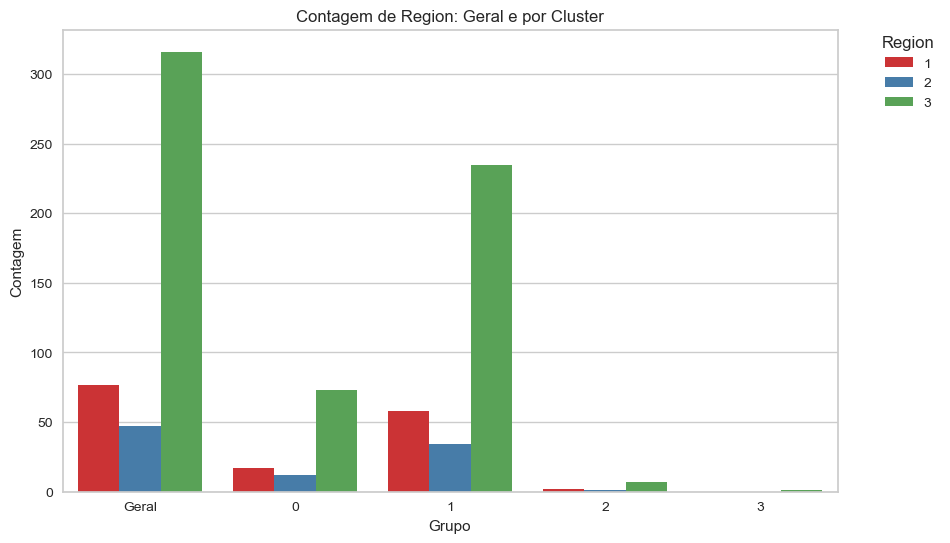

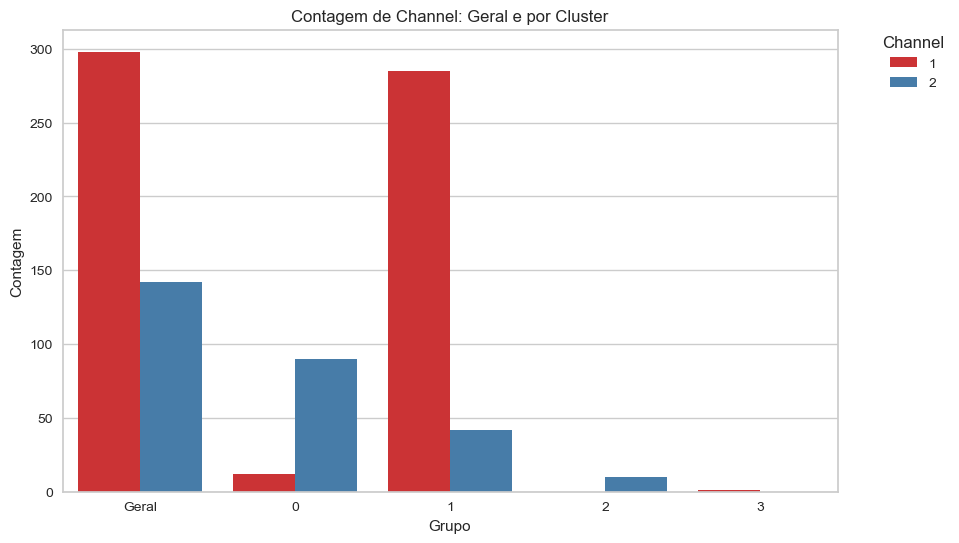

In [17]:
# selecionando apenas as variáveis categoricas
categorical_vars = ['Region', 'Channel']  

for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    
    # Criar uma nova coluna 'Grupo' que mantém os clusters e adiciona 'Geral' apenas para a plotagem
    wholesale_customers['Grupo'] = wholesale_customers['cluster'].astype(str)
    
    # Criar uma cópia temporária para o grupo 'Geral' contendo todas as observações
    wholesale_customers_geral = wholesale_customers.copy()
    wholesale_customers_geral['Grupo'] = 'Geral'
    
    # Concatenar os dados para garantir que 'Geral' contenha todos os dados e os clusters fiquem separados
    wholesale_customers_combined = pd.concat([wholesale_customers, wholesale_customers_geral])
    
    # Reordenar o Grupo para que 'Geral' fique em primeiro lugar
    wholesale_customers_combined['Grupo'] = pd.Categorical(wholesale_customers_combined['Grupo'], 
                                                           categories=['Geral', '0', '1', '2', '3'],
                                                           ordered=True)
    
    # Plotar o gráfico de barras com Geral e Cluster no eixo X e as categorias como as cores (legenda)
    sns.countplot(x='Grupo', hue=var, data=wholesale_customers_combined, palette='Set1')
    
    # Ajustar o título e exibir
    plt.title(f'Contagem de {var}: Geral e por Cluster')
    plt.xlabel('Grupo')
    plt.ylabel('Contagem')
    
    # Mover a legenda para a direita
    plt.legend(title=var, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
    
    plt.show()